In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import tensorflow.keras.backend as K
import tensorflow as tf


from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


from scipy.optimize import minimize

from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.transform import pyramid_gaussian, rescale

In [30]:
def show_img(image):
    fig, ax = plt.subplots(figsize=(18, 15))
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def preprocess_img(image):
    return preprocess_input(np.expand_dims(image.astype(K.floatx()), 0))
    
def postprocess_img(image):
    image[:, :, :, 0] += 103.939
    image[:, :, :, 1] += 116.779
    image[:, :, :, 2] += 123.68
    return np.clip(image[:, :, :, ::-1], 0, 255).astype('uint8')[0]



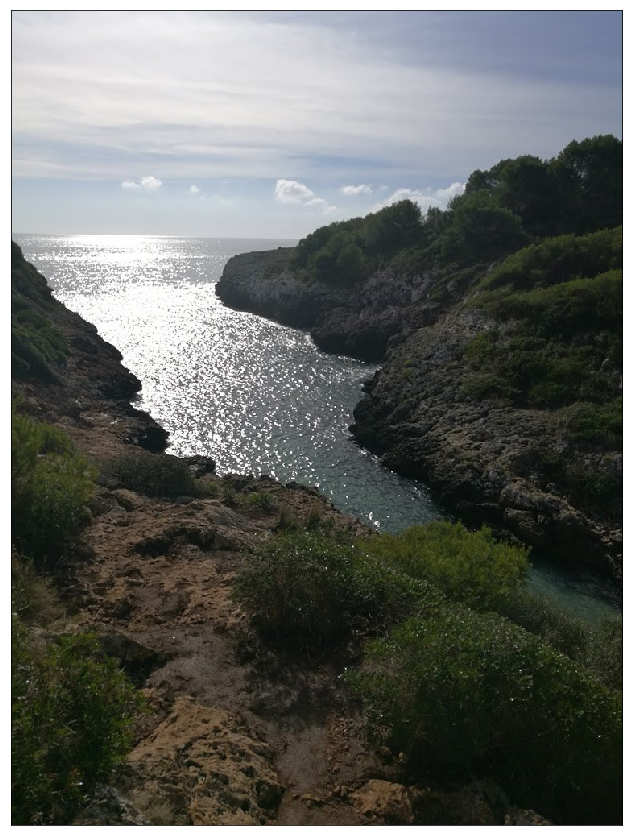

In [31]:
original_image = 'mallorca.jpg'
final_image = 'mallorca_dream.jpg'

original_image_array = imread(original_image)
show_img(original_image_array)

### Prepare the Gaussian Pyramid

In [33]:

original_image_as_float = img_as_float(original_image_array)
pyramid = list(pyramid_gaussian(original_image_as_float, downscale=2, max_layer=5))

for i, image in enumerate(pyramid):
    pyramid[i] = img_as_ubyte(pyramid[i])
    print('Bild {}) Größe: {}'.format(i, pyramid[i].shape))

Bild 0) Größe: (1013, 760, 3)
Bild 1) Größe: (507, 380, 3)
Bild 2) Größe: (254, 190, 3)
Bild 3) Größe: (127, 95, 3)
Bild 4) Größe: (64, 48, 3)
Bild 5) Größe: (32, 24, 3)


C:\PyProgramme\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [35]:
model = VGG19(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [36]:
layers = {
    'block5_conv1': 0.001,
    'block5_conv2': 0.001,
}



In [37]:
image_l2_weight = 0.005
loss_tensor = 0.0

for layer, weight in layers.items():
    loss_tensor += (-weight * K.sum(K.square(model.get_layer(layer).output)))
    
loss_tensor += image_l2_weight * K.sum(K.square(model.layers[0].input))

_loss_function = K.function(inputs=[model.layers[0].input], outputs=[loss_tensor])

In [38]:
loss_gradient = K.gradients(loss=loss_tensor, variables=[model.layers[0].input])
_gradient_function = K.function(inputs=[model.layers[0].input], outputs=loss_gradient)

In [39]:
def dd_loss(x, shape):
    return _loss_function([x.reshape(shape)])[0]

def dd_gradient(x, shape):
    return _gradient_function([x.reshape(shape)])[0].flatten().astype(np.float64)

In [41]:
def process_image(image, iterations=2):
    
    bounds = np.ndarray(shape=(image.flatten().shape[0], 2))
    bounds[:, 0] = -128.0
    bounds[:, 1] = 128.0

    
    x0 = image.flatten()

    
    result = minimize(fun=dd_loss, 
                      x0=x0, 
                      args=list(image.shape), 
                      jac=dd_gradient, 
                      method='L-BFGS-B', 
                      bounds=bounds, 
                      options={'maxiter': iterations})
    
    return postprocess_img(np.copy(result.x.reshape(image.shape)))

In [42]:
processed_image = None

for i, image in enumerate(pyramid[::-1]):
    print('Traumpyramide: {} {}'.format(len(pyramid)-i, image.shape))
    
    if processed_image is None:
        processed_image = process_image(preprocess_img(image))
    else:
        h, w = image.shape[0:2]
        ph, pw = processed_image.shape[0:2]
        rescaled_image = rescale(processed_image, order=5, scale=(float(h)/float(ph), float(w)/float(pw)))
        combined_image = img_as_ubyte((1.2*img_as_float(image) + 0.8*rescaled_image) / 2.0)
        processed_image = process_image(preprocess_img(combined_image), iterations=5)
print("Ausgeträumt!")

Traumpyramide: 6 (32, 24, 3)
Traumpyramide: 5 (64, 48, 3)


C:\PyProgramme\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\PyProgramme\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Traumpyramide: 4 (127, 95, 3)
Traumpyramide: 3 (254, 190, 3)
Traumpyramide: 2 (507, 380, 3)
Traumpyramide: 1 (1013, 760, 3)
Ausgeträumt!


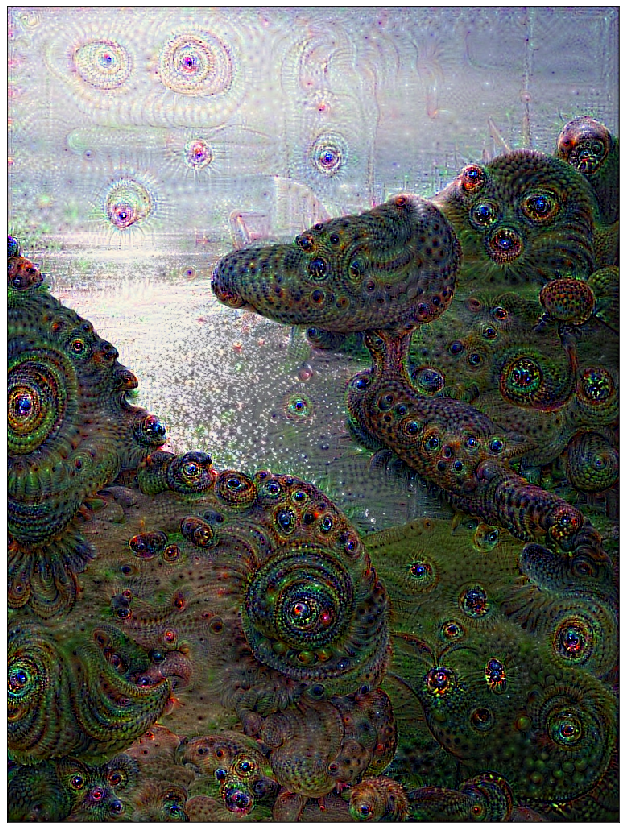

In [80]:
show_img(processed_image)